In [1]:
import gc
import glob
import math
import os
import random
import re
import sys
import time

import cv2
import matplotlib
import matplotlib.pyplot as plt
import model as modellib
import numpy as np
import pandas as pd
import utils
import visualize
from config import Config
from model import log
from skimage.io import concatenate_images, imread, imread_collection, imshow
from skimage.transform import resize
from tqdm import tqdm
from sklearn.utils import shuffle

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)


ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/w/anaconda3/envs/idp3exp/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from mrcnn_api import MRCNN_API, GISSConfig, save_to_avro, read_avro

In [3]:
config = GISSConfig()
class_names = ['BG', 'car', 'building', 'human', 'truck', 'container', 'winter_car']


src_o = '/home/w/Projects/PW-GISS/input/90oblot_depth/'
src_o_images = np.sort(glob.glob(src_o + '*.JPG'))

weights_src = '/home/w/Projects/PW-GISS/scripts/Mask_RCNN/logs/giss20180201T1945/'
weights_file = weights_src + 'mask_rcnn_giss_0073.h5'

In [4]:
mrcnn_model = MRCNN_API(config, model_path=weights_file)

/home/w/anaconda3/envs/idp3exp/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/w/anaconda3/envs/idp3exp/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


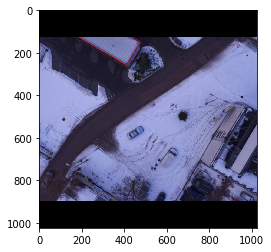

In [5]:
img_pad = mrcnn_model.load_single_image(src_o_images[0], resize_and_pad=True)
plt.imshow(img_pad)

Loading weights from: /home/w/Projects/PW-GISS/scripts/Mask_RCNN/logs/giss20180201T1945/mask_rcnn_giss_0073.h5
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  233.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  129.10000
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000


/home/w/anaconda3/envs/idp3exp/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/w/anaconda3/envs/idp3exp/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Time it took for inference: 3.0499908924102783


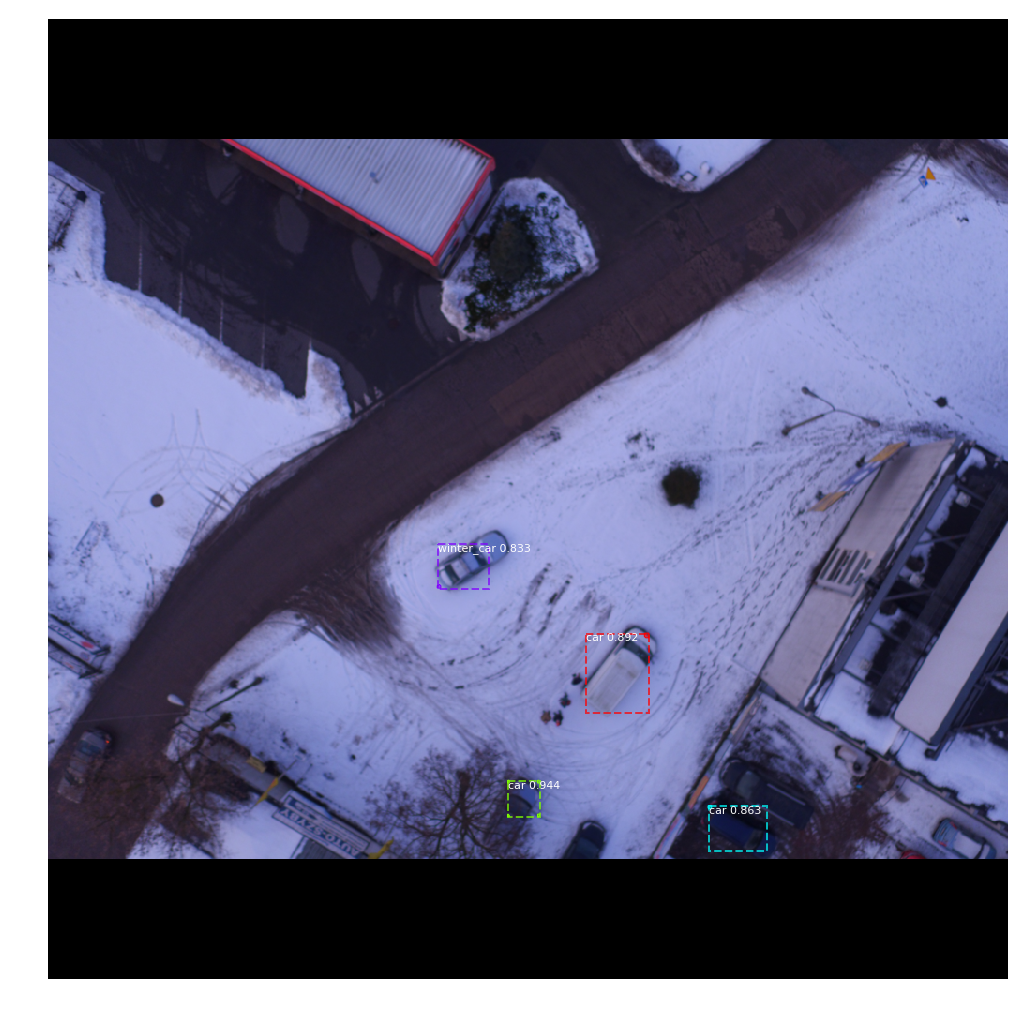

ymin  xmin  ymax  xmax                                           filename  \
0   812   490   851   524  /home/w/Projects/PW-GISS/input/90oblot_depth/D...   
1   655   573   740   641  /home/w/Projects/PW-GISS/input/90oblot_depth/D...   
2   839   704   887   766  /home/w/Projects/PW-GISS/input/90oblot_depth/D...   
3   559   415   607   470  /home/w/Projects/PW-GISS/input/90oblot_depth/D...   

   class  confidence   x   y  
0      1    0.944070  34  39  
1      1    0.892440  68  85  
2      1    0.862741  62  48  
3      6    0.832677  55  48

In [6]:
img_preds = mrcnn_model.predict_image(img_pad, class_names, visualize_predictions=True)

df_preds = mrcnn_model.create_predictions_df(src_o_images[0], img_preds)
df_preds

In [7]:
dfs = df_preds.iloc[0, :]

In [8]:
save_to_avro(df_preds, schema_filename='mrcnn_b.avsc')
preds_list = read_avro()